In [1]:
import polars as pl
import functools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit, minimize, least_squares
from IPython.display import clear_output
from matplotlib import ticker
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [2]:
def get_noise_label(hybrid_mixing_shift):
    if hybrid_mixing_shift == 0.0:
        return "balanced"
    if hybrid_mixing_shift <= -1e2:
        return "masked"
    if hybrid_mixing_shift >= 1e2:
        return "uniform"
    if hybrid_mixing_shift < 0:
        return "low-uniform"
    if hybrid_mixing_shift > 0:
        return "high-uniform"

colors = {
    -1000.0: (58, 76, 192),
    -2.0: (141, 175, 253),
    0.0: (122, 220, 121),
    2.0: (243, 152, 121),
    1000.0: (179, 3, 38),
}

In [3]:
df_ = pl.read_csv("isoflops.csv")

df_ = df_.filter(pl.col("batch_size") < 1024)
df_grouped = df_.group_by("hybrid_mixing_shift", "non_emb_params", "total_flops").agg(pl.all().sort_by("target_loss").first())
df_grouped = df_grouped.filter((pl.col("steps") <= 100000) & (pl.col("steps") > 5000)).sort("non_emb_params")
df_grouped = df_grouped.filter(pl.col("target_loss") < 4.0)

In [4]:
df_grouped["non_emb_params"].unique() / 1e6

shape: (5,)
Series: 'non_emb_params' [f64]
[
	25.22368
	49.24224
	85.064448
	201.556992
	566.662656
]

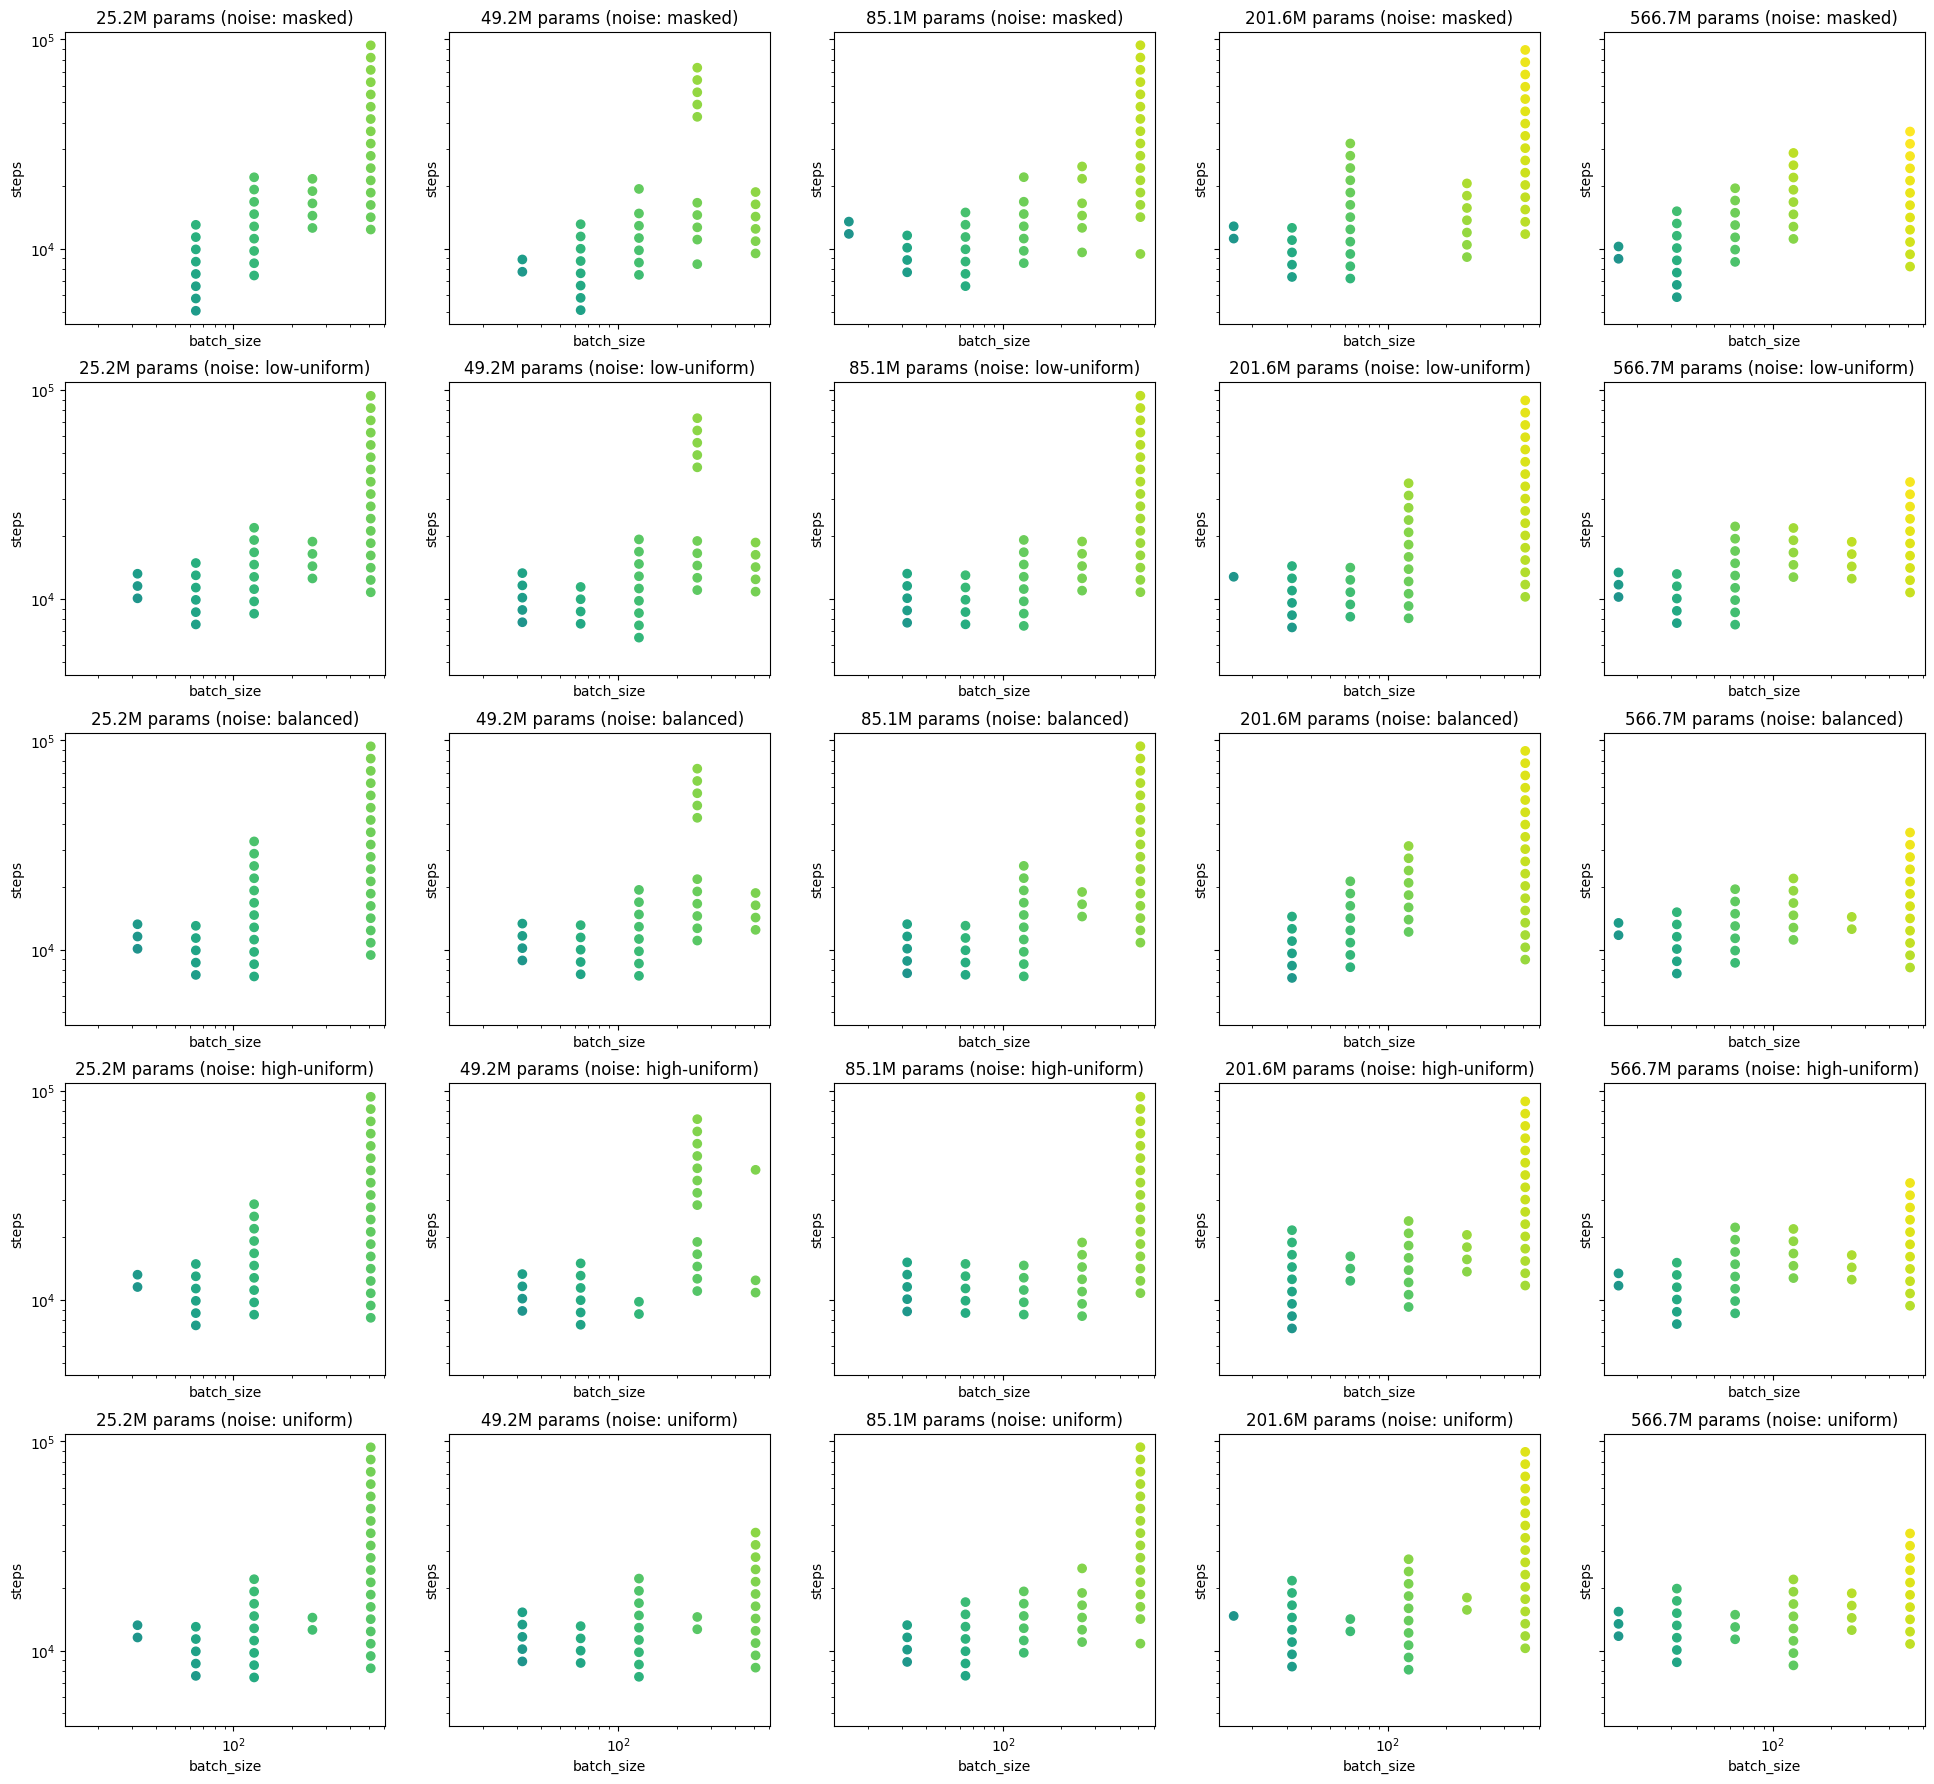

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x.clip(-10, 10)))

fig, axs = plt.subplots(5, len(df_["non_emb_params"].unique()), figsize=(24, 22), sharex=True, sharey=True)

vmin, vmax = df_["target_loss"].min(), df_["target_loss"].max()

for i, ((params, ), dfi) in enumerate(df_grouped.group_by("non_emb_params")):
    for j, ((hybrid_mixing_shift, ), dfj) in enumerate(dfi.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
        ax = axs[j, i]
        # ax.scatter(dfj["batch_size"], dfj["steps"], c=sigmoid(dfj["hybrid_mixing_shift"]))
        ax.scatter(dfj["batch_size"], dfj["steps"], c=dfj["target_loss"], cmap="viridis_r", vmin=vmin, vmax=vmax)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("batch_size")
        ax.set_ylabel("steps")
        ax.set_title(f"{params/1e6:.1f}M params (noise: {get_noise_label(hybrid_mixing_shift)})")

In [6]:
scaling_laws = {}
fit_in_logspace = True
n_bootstraps = 10000
n_jobs = -1
min_flops = 5e17
lsq_loss = "huber"

def power_law_decay_2d(X, Y, a, alpha, b, beta, E):
    return E + a * X**-alpha + b * Y**-beta

def power_law_decay_1d(X, a, alpha, E):
    return E + a * X**-alpha

def power_law_growth_1d(X, a, alpha, E):
    return E + a * X**alpha

# def bootstrap_fit(dfi, base_resid, p1_0, seed):
#     bootstrap_df = dfi.sample(n=len(dfi), with_replacement=True, seed=seed)
#     dfi_grouped = bootstrap_df.group_by("total_flops_per_tok", "flops").agg(pl.all().sort_by("target_loss").first())
#     bootstrap_P1 = dfi_grouped["total_flops_per_tok"].to_numpy()
#     bootstrap_D1 = dfi_grouped["tokens"].to_numpy()
#     bootstrap_L1 = dfi_grouped["target_loss"].to_numpy()

#     L_star_approx = 100 * (bootstrap_P1 * bootstrap_D1)**(-0.047)
#     optimality = bootstrap_L1 / L_star_approx
#     norm_optimality = optimality / optimality.min()
#     mask = norm_optimality <= optimality_threshold

#     bootstrap_resid1 = functools.partial(base_resid, functools.partial(power_law, bootstrap_P1[mask], bootstrap_D1[mask]), bootstrap_L1[mask])
#     bootstrap_sol1 = least_squares(bootstrap_resid1, p1_0, bounds=(1e-8, np.inf), loss=lsq_loss)

#     return bootstrap_sol1.x



for i, ((hybrid_mixing_shift, ), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    scaling_law = {}

    #### HOFFMANN (Chinchilla) ####

    M = dfi["total_flops_per_tok"].to_numpy().astype(np.float64)
    D = dfi["tokens"].to_numpy().astype(np.float64)
    L = dfi["target_loss"].to_numpy().astype(np.float64)
    C = M * D
    mask = C >= min_flops

    transform = lambda x: x
    if fit_in_logspace:
        transform = np.log

    def base_resid(f, y, p):
        return transform(f(*p)) - transform(y)

    func = power_law_decay_2d
    resid = functools.partial(base_resid, functools.partial(func, M[mask], D[mask]), L[mask])
    
    p1_0 = (20.0, 0.23, 300.0, 0.29, 1.0)

    sol1 = least_squares(resid, p1_0, bounds=(1e-8, np.inf), loss=lsq_loss)

    # # chunk to get a nice tqdm progress (joblib finishes batches at once)
    # chunk_size = 64
    # seeds = list(range(n_bootstraps))
    # bootstrap_params = []
    # for start in tqdm(range(0, n_bootstraps, chunk_size), desc=f"Bootstrapping shift={hybrid_mixing_shift}"):
    #     chunk = seeds[start:start + chunk_size]
    #     bootstrap_params.extend(
    #         Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(
    #             delayed(bootstrap_fit)(dfi, base_resid, sol1.x, seed) for seed in chunk
    #         )
    #     )
        
    # bootstrap_params = np.array(bootstrap_params)
    # m = bootstrap_params.mean(axis=0)
    # std = bootstrap_params.std(axis=0)

    # print(f"Mean {get_noise_label(hybrid_mixing_shift):10s}: a={m[0]:.3g},\talpha={m[1]:.3g},\tb={m[2]:.3g},\tbeta={m[3]:.3g},\tE={m[4]:.3g}")
    # print(f"Std  {get_noise_label(hybrid_mixing_shift):10s}: a={std[0]:.3g},\talpha={std[1]:.3g},\tb={std[2]:.3g},\tbeta={std[3]:.3g},\tE={std[4]:.3g}")
    print(f"Fit  {get_noise_label(hybrid_mixing_shift)+':':20s} a={sol1.x[0]:.3g},\talpha={sol1.x[1]:.3g},\tb={sol1.x[2]:.3g},\tbeta={sol1.x[3]:.3g},\tE={sol1.x[4]:.3g}")

    scaling_law["chinchilla"] = {
        "data": {"M": M, "D": D, "L": L, "C": C},
        "func": func,
        "resid": resid,
        "args": (M, D),
        "mask": mask,
        "y": L,
        "p": sol1.x,
        # "p_bootstrap": bootstrap_params
    }

    #### END HOFFMANN ####

    #### IsoFLOP-based (interpolated) ####

    data = []
    for j, ((non_emb_flops,), dfj) in enumerate(dfi.group_by("non_emb_flops")):
        if len(dfj) < 3:
            continue
        tokens = dfj["tokens"]
        flops_per_tok = dfj["total_flops_per_tok"]
        loss = dfj["target_loss"]

        # fit parabola through points
        coeff = np.polyfit(np.log(tokens), np.log(loss), 2)
        opt_tok = np.exp(-coeff[1] / (2 * coeff[0]))

        coeff = np.polyfit(np.log(flops_per_tok), np.log(loss), 2)
        opt_flops_per_tok = np.exp(-coeff[1] / (2 * coeff[0]))
        opt_loss = np.exp(np.polyval(coeff, np.log(opt_flops_per_tok)))

        data.append({
            "non_emb_params": dfj["non_emb_params"].first(),
            "non_emb_flops": non_emb_flops,
            "total_flops": opt_tok * opt_flops_per_tok,
            "opt_tokens": opt_tok,
            "opt_flops_per_tok": opt_flops_per_tok,
            "opt_loss": opt_loss,
        })

    dfj = pl.DataFrame(data)
    M = dfj["opt_flops_per_tok"].to_numpy()
    D = dfj["opt_tokens"].to_numpy()
    C = dfj["total_flops"].to_numpy()
    L = dfj["opt_loss"].to_numpy()
    mask = C >= min_flops

    func = functools.partial(power_law_growth_1d, E=0.0)
    resid = functools.partial(base_resid, functools.partial(func, C[mask]), D[mask])
    p0 = (1.0, 0.5)
    sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss=lsq_loss)
    scaling_law["opt_data_interpolated"] = {
        "data": {"M": M, "D": D, "L": L, "C": C},
        "func": func,
        "resid": resid,
        "args": (C,),
        "mask": mask,
        "y": D,
        "p": sol.x,
    }

    func = functools.partial(power_law_growth_1d, E=0.0)
    resid = functools.partial(base_resid, functools.partial(func, C[mask]), M[mask])
    p0 = (1.0, 0.5)
    sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss=lsq_loss)
    scaling_law["opt_flops_per_tok_interpolated"] = {
        "data": {"M": M, "D": D, "L": L, "C": C},
        "func": func,
        "resid": resid,
        "args": (C,),
        "mask": mask,
        "y": M,
        "p": sol.x,
    }

    func = functools.partial(power_law_decay_1d)
    resid = functools.partial(base_resid, functools.partial(func, C[mask]), L[mask])
    p0 = (30.0, 0.1, 0.5)
    sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss=lsq_loss)
    scaling_law["opt_loss_interpolated"] = {
        "data": {"M": M, "D": D, "L": L, "C": C},
        "func": func,
        "resid": resid,
        "args": (C,),
        "mask": mask,
        "y": L,
        "p": sol.x,
    }

    #### END IsoFLOP-based (interpolated) ####

    #### IsoFLOP-based (raw) ####

    dfj = dfi.group_by("non_emb_flops").agg(pl.all().sort_by("target_loss").first()).sort("total_flops_per_tok")
    M = dfj["total_flops_per_tok"].to_numpy().astype(np.float64)
    D = dfj["tokens"].to_numpy().astype(np.float64)
    C = dfj["total_flops"].to_numpy().astype(np.float64)
    L = dfj["target_loss"].to_numpy().astype(np.float64)

    mask = C > min_flops

    func = functools.partial(power_law_growth_1d, E=0.0)
    resid = functools.partial(base_resid, functools.partial(func, C[mask]), D[mask])
    p0 = (1.0, 0.5)
    sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss=lsq_loss)
    scaling_law["opt_data_raw"] = {
        "data": {"M": M, "D": D, "L": L, "C": C},
        "func": func,
        "resid": resid,
        "args": (C,),
        "mask": mask,
        "y": D,
        "p": sol.x,
    }

    func = functools.partial(power_law_growth_1d, E=0.0)
    resid = functools.partial(base_resid, functools.partial(func, C[mask]), M[mask])
    p0 = (1.0, 0.5)
    sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss=lsq_loss)
    scaling_law["opt_flops_per_tok_raw"] = {
        "data": {"M": M, "D": D, "L": L, "C": C},
        "func": func,
        "resid": resid,
        "args": (C,),
        "mask": mask,
        "y": M,
        "p": sol.x,
    }

    func = functools.partial(power_law_decay_1d)
    resid = functools.partial(base_resid, functools.partial(func, C[mask]), L[mask])
    p0 = (30.0, 0.1, 0.5)
    sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss=lsq_loss)
    scaling_law["opt_loss_raw"] = {
        "data": {"M": M, "D": D, "L": L, "C": C},
        "func": func,
        "resid": resid,
        "args": (C,),
        "mask": mask,
        "y": L,
        "p": sol.x,
    }

    #### END IsoFLOP-based (raw) ####

    #### Compute-optimal frontier (direct) ####

    dfj = dfi.group_by("non_emb_flops").agg(pl.all().sort_by("target_loss").first()).sort("total_flops_per_tok")
    M = dfj["total_flops_per_tok"].to_numpy().astype(np.float64)
    D = dfj["tokens"].to_numpy().astype(np.float64)
    C = dfj["total_flops"].to_numpy().astype(np.float64)
    L = dfj["target_loss"].to_numpy().astype(np.float64)

    mask = C > 1e17

    func = functools.partial(power_law_decay_1d)
    resid = functools.partial(base_resid, functools.partial(func, C[mask]), L[mask])
    p0 = (30.0, 0.1, 0.5)
    sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss=lsq_loss)
    scaling_law["compute_optimal_loss_direct"] = {
        "data": {"M": M, "D": D, "L": L, "C": C},
        "func": func,
        "resid": resid,
        "args": (C,),
        "mask": mask,
        "y": L,
        "p": sol.x,
    }

    #### END Compute-optimal frontier (direct) ####

    scaling_laws[hybrid_mixing_shift] = scaling_law

Fit  masked:              a=342,	alpha=0.317,	b=2.14e+03,	beta=0.373,	E=2.22
Fit  low-uniform:         a=713,	alpha=0.358,	b=2.15e+03,	beta=0.372,	E=2.29
Fit  balanced:            a=1.03e+03,	alpha=0.378,	b=1.89e+03,	beta=0.364,	E=2.32
Fit  high-uniform:        a=461,	alpha=0.331,	b=1.75e+03,	beta=0.36,	E=2.25
Fit  uniform:             a=464,	alpha=0.331,	b=1.72e+03,	beta=0.359,	E=2.25


In [7]:
# coefficient_fits = [s["p_bootstrap"] for s in scaling_laws.values()]

In [8]:
# # quick sanity check of coefficients
# import numpy as np
# from scipy.stats import permutation_test

# def stat(x, y):
#     return np.mean(x) - np.mean(y)

# res = permutation_test((coefficient_fits[-1][:,1], coefficient_fits[0][:,1]), stat,
#                        vectorized=False, permutation_type='independent', n_resamples=1_000, alternative='less')
# print(res.pvalue)  # tests H1: mean(a) < mean(b)

In [9]:
# from scipy.stats import ttest_ind
# # H1: mean(a) < mean(b)
# t = ttest_ind(coefficient_fits[-1][:,1], coefficient_fits[0][:,1], equal_var=False, alternative='less')
# print(t.statistic, t.pvalue)

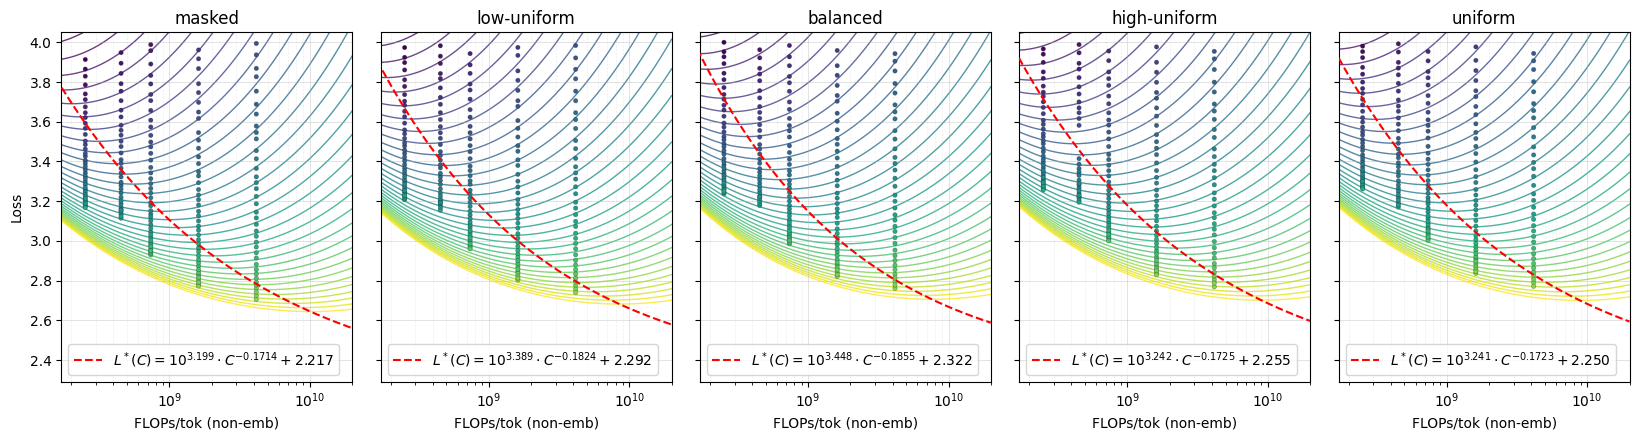

In [10]:

fig, axs = plt.subplots(1, 5, figsize=(17, 4.5), sharex=True, sharey="row")

flop_targets = np.logspace(18, np.log10(4e21), 32)

def color(x):
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(vmin=np.log(flop_targets).min(), vmax=np.log(flop_targets).max())
    return cmap(norm(np.log(x)))


def eval_bootstrap_params(bootstrap_array, params, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    L_star_P = E + a*(alpha + beta)/beta * params[None,:]**(-alpha)
    lower = np.percentile(L_star_P, percentile_alpha, axis=0)
    upper = np.percentile(L_star_P, 100 - percentile_alpha, axis=0)
    return lower, upper



for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    scaling_law = scaling_law["chinchilla"]
    ax = axs[i]
    for flops in flop_targets:
        params = np.logspace(8, np.log10(2e10), 100)
        tokens = flops / (6 * params)

        loss = scaling_law["func"](params, tokens, *scaling_law["p"])
        ax.plot(params, loss, color=color(flops), alpha=0.8, zorder=1, linewidth=1.0)

        batch_size = np.logspace(3, 7, 100)
        steps = flops / (6 * params[:, None] * batch_size[None, :])

    dfi = df_grouped.filter(pl.col("hybrid_mixing_shift") == hybrid_mixing_shift)
    xs = dfi["total_flops_per_tok"]
    ys = dfi["target_loss"]
    c = dfi["tokens"] * xs * 6
    ax.scatter(xs, ys, c=np.log(c), cmap="viridis", vmin=np.log(flop_targets.min()), vmax=np.log(flop_targets.max()), edgecolor=(0, 0, 0, 0.3), linewidth=0.5, s=10, zorder=2)

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))
    L_star_P = E + a*(alpha + beta)/beta * params**(-alpha)
    ax.plot(params, L_star_P, linestyle="--", color="red", label="$L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E), zorder=3)

    # lower, upper = eval_bootstrap_params(scaling_law["p_bootstrap"].T, params)
    # ax.fill_between(params, lower, upper, alpha=0.25, color="red")


    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")
    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_ylim(None, 4.05)
    ax.set_xlim(1.7e8, 2e10)
    ax.legend()


    ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5, zorder=0)
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2, zorder=0)

for ax in axs.flatten():
    ax.set_xlabel("FLOPs/tok (non-emb)")

axs[0].set_ylabel("Loss")

fig.tight_layout(w_pad=-2.0)
fig.show()
#fig.savefig("plots/scaling_laws.pdf", dpi=300, bbox_inches="tight")

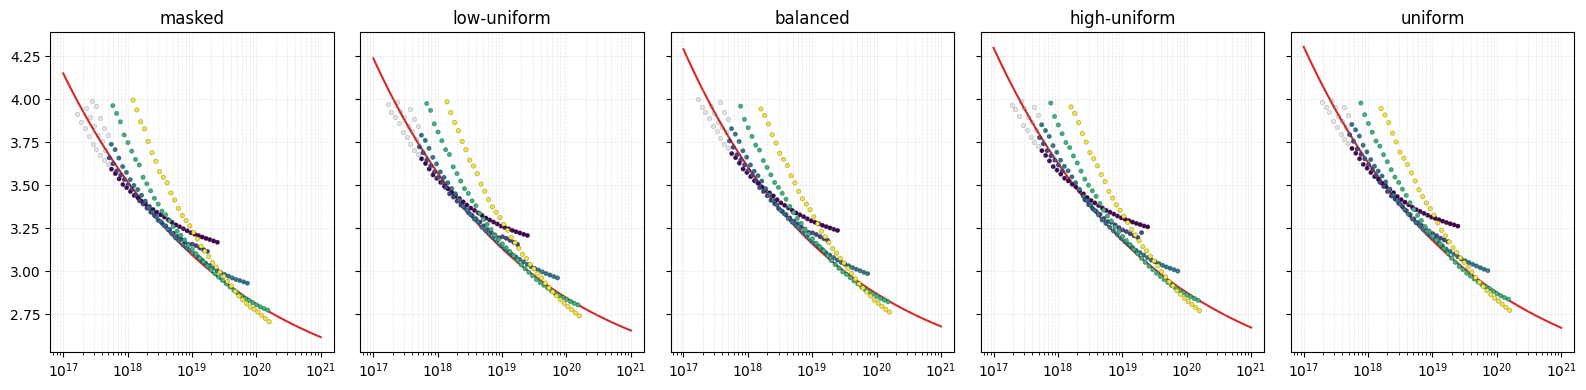

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, hybrid_mixing_shift in enumerate(scaling_laws.keys()):
    scaling_law = scaling_laws[hybrid_mixing_shift]["chinchilla"]
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    M = scaling_law["args"][0]
    D = scaling_law["args"][1]
    L = scaling_law["y"]
    mask = scaling_law["mask"]

    flops = M * D
    x = flops
    y = L

    vmin, vmax = M.min(), M.max()
    ax.scatter(x[mask], y[mask], c=np.log(M[mask]), vmin=np.log(vmin), vmax=np.log(vmax), s=10, cmap="viridis", edgecolor=(0,0,0,0.3), linewidth=0.5)
    ax.scatter(x[~mask], y[~mask], c="gray", alpha=0.2, s=10, edgecolor=(0,0,0,0.3), linewidth=0.5)

    xs = np.logspace(np.log10(1e17), np.log10(1e21), 100)    
    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))
    L_star_C = E + C_star_a * (xs)**(C_star_alpha)
    ax.plot(xs, L_star_C, linestyle="-", color="C3", zorder=0)

    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

    # if i == 0:
    #     for num_params in sorted(set(P)):
    #         ax.scatter([0], [4.4], c=np.log(num_params), vmin=np.log(vmin), vmax=np.log(vmax), s=10, edgecolor=(0,0,0,0.3), linewidth=0.5, label=f"{num_params/1e6:.1f}M")
    #     ax.legend()

fig.tight_layout()

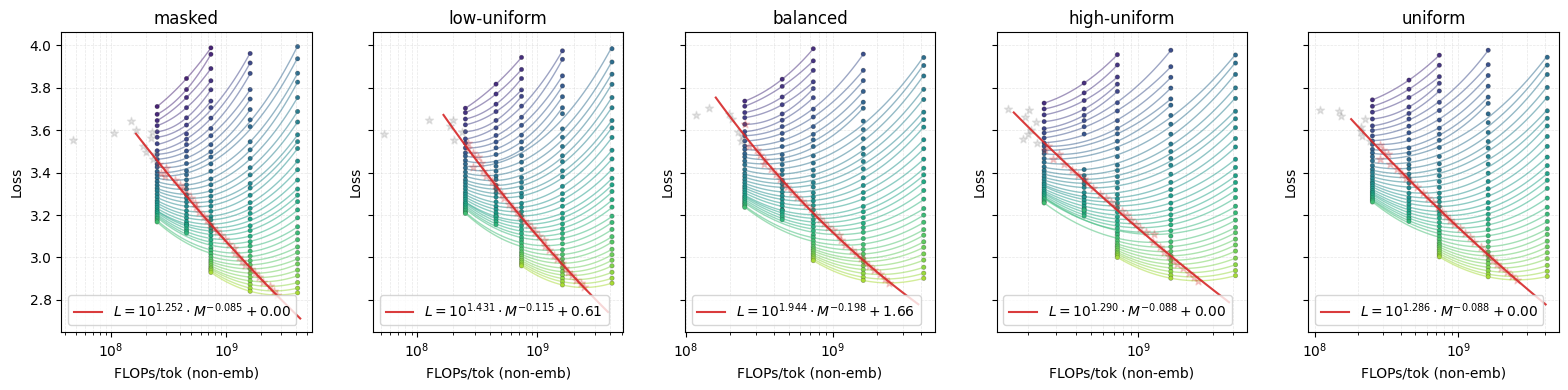

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    vmin, vmax = np.log(dfi["non_emb_flops"].min()), np.log(dfi["non_emb_flops"].max())

    def color(x):
        cmap = plt.get_cmap("viridis")
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        return cmap(norm(np.log(x)))

    dfi = dfi.sort("non_emb_flops")
    opt_xs = []
    opt_ys = []
    for j, ((non_emb_flops,), dfj) in enumerate(dfi.group_by("non_emb_flops")):
        if len(dfj) < 3:
            continue
        flops_per_tok = dfj["total_flops_per_tok"]
        loss = dfj["target_loss"]
        ax.scatter(flops_per_tok, loss, c=np.log(dfj["non_emb_flops"]), vmin=vmin, vmax=vmax, s=10, cmap="viridis", edgecolor=(0,0,0,0.3), linewidth=0.5)

        # fit parabola through points
        coeff = np.polyfit(np.log(flops_per_tok), np.log(loss), 2)
        x_fit = np.logspace(np.log10(flops_per_tok.min()), np.log10(flops_per_tok.max()), 100)
        y_fit = np.exp(np.polyval(coeff, np.log(x_fit)))
        ax.plot(x_fit, y_fit, color=color(non_emb_flops), alpha=0.5, linewidth=1.0)
        opt_x = np.exp(-coeff[1] / (2 * coeff[0]))
        opt_y = np.exp(np.polyval(coeff, np.log(opt_x)))
        if opt_x >= x_fit.min() and opt_x <= x_fit.max():
            c = "C3"
            opt_xs.append(opt_x)
            opt_ys.append(opt_y)
        else:
            c = "gray"
        ax.scatter([opt_x], [opt_y], marker="*", color=c, zorder=3, alpha=0.2)

    opt_xs = np.array(opt_xs)
    opt_ys = np.array(opt_ys)
    if len(opt_xs) > 1:
        # fit power law through optimal points
        def resid(p):
            a, alpha, E = p
            return np.log(E + a * opt_xs**-alpha) - np.log(opt_ys)
        p0 = (1.0, 0.1, 1.0)
        sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss="huber")
        a, alpha, E = sol.x
        x_fit = np.logspace(np.log10(opt_xs.min())-0.2, np.log10(opt_xs.max())+0.2, 100)
        y_fit = E + a * x_fit**-alpha
        label = "$L = 10^{{{:.3f}}} \\cdot M^{{-{:.3f}}} + {:.2f}$".format(np.log10(a), alpha, E)
        ax.plot(x_fit, y_fit, color="C3", alpha=0.9, zorder=4, label=label)

    ax.legend()

    ax.set_xlabel("FLOPs/tok (non-emb)")
    ax.set_ylabel("Loss")

    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

fig.tight_layout()

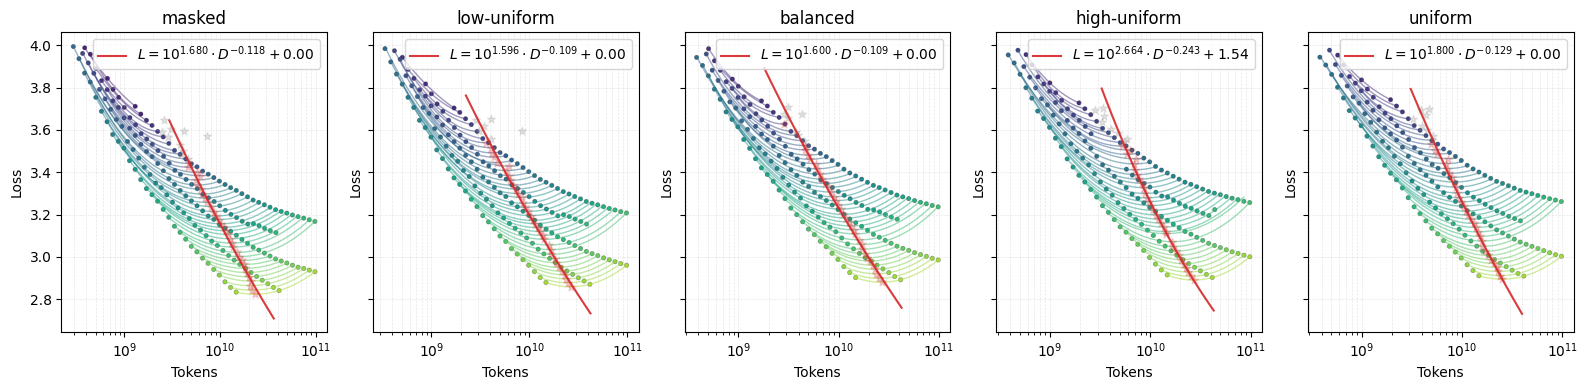

In [15]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    scaling_law = scaling_laws[hybrid_mixing_shift]
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    vmin, vmax = np.log(dfi["non_emb_flops"].min()), np.log(dfi["non_emb_flops"].max())

    def color(x):
        cmap = plt.get_cmap("viridis")
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        return cmap(norm(np.log(x)))

    dfi = dfi.sort("non_emb_flops")
    opt_xs = []
    opt_ys = []
    for j, ((non_emb_flops,), dfj) in enumerate(dfi.group_by("non_emb_flops")):
        if len(dfj) < 3:
            continue
        tokens = dfj["tokens"]
        loss = dfj["target_loss"]
        ax.scatter(tokens, loss, c=np.log(dfj["non_emb_flops"]), vmin=vmin, vmax=vmax, s=10, cmap="viridis", edgecolor=(0,0,0,0.3), linewidth=0.5)

        # fit parabola through points
        coeff = np.polyfit(np.log(tokens), np.log(loss), 2)
        x_fit = np.logspace(np.log10(tokens.min()), np.log10(tokens.max()), 100)
        y_fit = np.exp(np.polyval(coeff, np.log(x_fit)))
        ax.plot(x_fit, y_fit, color=color(non_emb_flops), alpha=0.5, linewidth=1.0)
        opt_x = np.exp(-coeff[1] / (2 * coeff[0]))
        opt_y = np.exp(np.polyval(coeff, np.log(opt_x)))
        if opt_x >= x_fit.min() and opt_x <= x_fit.max():
            c = "C3"
            opt_xs.append(opt_x)
            opt_ys.append(opt_y)
        else:
            c = "gray"
        ax.scatter([opt_x], [opt_y], marker="*", color=c, zorder=3, alpha=0.2)

    opt_xs = np.array(opt_xs)
    opt_ys = np.array(opt_ys)
    if len(opt_xs) > 1:
        # fit power law through optimal points
        def resid(p):
            a, alpha, E = p
            return np.log(E + a * opt_xs**-alpha) - np.log(opt_ys)
        p0 = (1.0, 0.1, 1.0)
        sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss="huber")
        a, alpha, E = sol.x
        x_fit = np.logspace(np.log10(opt_xs.min())-0.2, np.log10(opt_xs.max())+0.2, 100)
        y_fit = E + a * x_fit**-alpha
        label = "$L = 10^{{{:.3f}}} \\cdot D^{{-{:.3f}}} + {:.2f}$".format(np.log10(a), alpha, E)
        ax.plot(x_fit, y_fit, color="C3", alpha=0.9, zorder=4, label=label)

    ax.legend(loc="upper right")

    ax.set_xlabel("Tokens")
    ax.set_ylabel("Loss")

    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

fig.tight_layout()

In [16]:
def plot_scaling_law(ax, scaling_law, x_symbol="C", y_symbol="L", min_x=5e16, max_x=2e21, growing=False):
    x = scaling_law["args"][0]
    y = scaling_law["y"]
    c = np.log(scaling_law["data"]["M"])
    mask = scaling_law["mask"]

    vmin, vmax = c.min(), c.max()
    ax.scatter(x[mask], y[mask], c=c[mask], vmin=vmin, vmax=vmax, s=10, cmap="viridis", edgecolor=(0,0,0,0.3), linewidth=0.5)
    ax.scatter(x[~mask], y[~mask], c="gray", alpha=0.2, s=10, edgecolor=(0,0,0,0.3), linewidth=0.5)

    p = scaling_law["p"]
    label = f"{y_symbol} = {p[0]:.3g} \\cdot {x_symbol}^{{{p[1]:.3g}}}"
    if len(p) > 2:
        if p[2] < 1e-7:
            label += f"+ 0.0"
        elif p[2] < 1e-3:
            label += f"+ 10^{{{np.log10(p[2]):.2f}}}"
        else:
            label += f"+ {p[2]:.3g}"

    xs = np.logspace(np.log10(min_x), np.log10(max_x), 100)
    y_star = scaling_law["func"](xs, *scaling_law["p"])
    ax.plot(xs, y_star, linestyle="-", color="C3", zorder=0, label=f"${label}$")

    handles, labels = ax.get_legend_handles_labels()

    leg_main = ax.legend(handles, labels)
    ax.add_artist(leg_main)


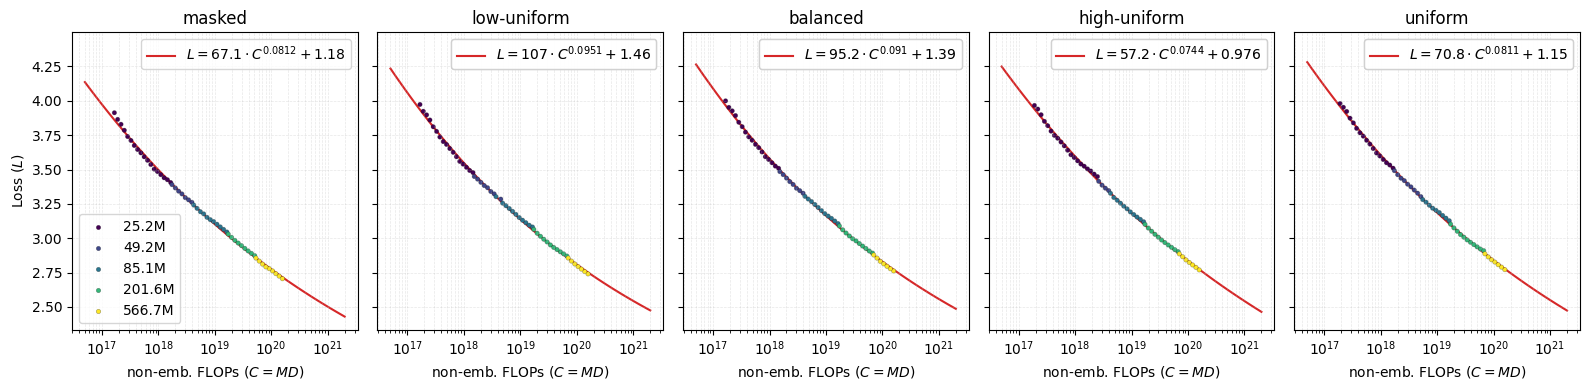

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    scaling_law = scaling_laws[hybrid_mixing_shift]["compute_optimal_loss_direct"]
    plot_scaling_law(ax, scaling_law)

    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

    ax.set_xlabel("non-emb. FLOPs ($C = MD$)")
    if i == 0:
        ax.set_ylabel("Loss ($L$)")
        param_handles = []
        param_labels = []
        vmin, vmax = dfi["non_emb_params"].min(), dfi["non_emb_params"].max()
        for num_flops, num_params in zip(sorted(set(M)), sorted(dfi["non_emb_params"].unique())):
            sc = ax.scatter([0], [4.4], c=np.log(num_params), vmin=np.log(vmin), vmax=np.log(vmax),
                            s=10, edgecolor=(0,0,0,0.3), linewidth=0.5)
            param_handles.append(sc)
            param_labels.append(f"{num_params/1e6:.1f}M")
        ax.legend(param_handles, param_labels, loc="lower left")



fig.tight_layout()

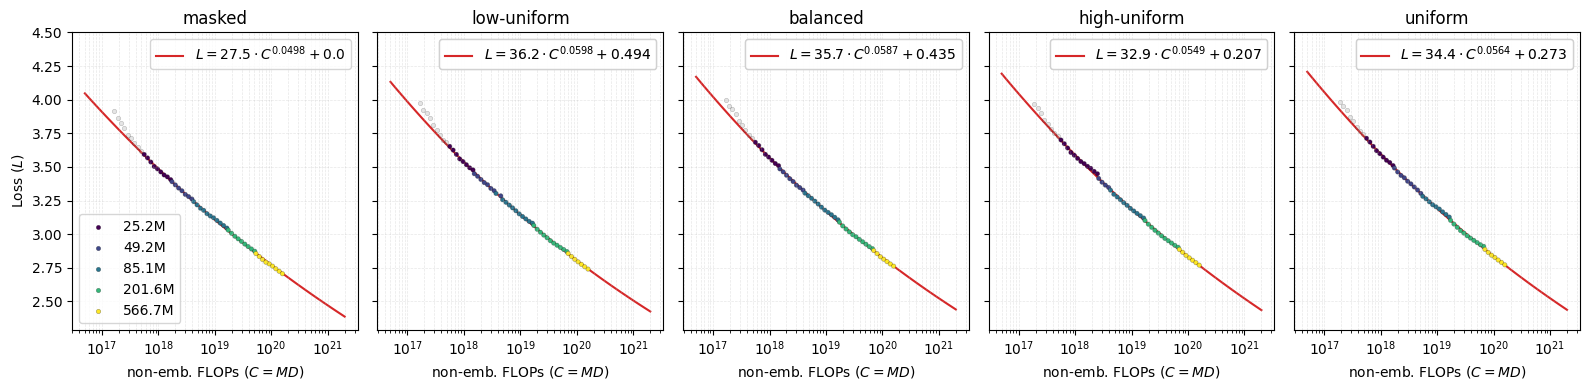

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    scaling_law = scaling_laws[hybrid_mixing_shift]["opt_loss_raw"]
    plot_scaling_law(ax, scaling_law)

    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

    ax.set_xlabel("non-emb. FLOPs ($C = MD$)")
    if i == 0:
        ax.set_ylabel("Loss ($L$)")
        param_handles = []
        param_labels = []
        vmin, vmax = dfi["non_emb_params"].min(), dfi["non_emb_params"].max()
        for num_flops, num_params in zip(sorted(set(M)), sorted(dfi["non_emb_params"].unique())):
            sc = ax.scatter([0], [4.4], c=np.log(num_params), vmin=np.log(vmin), vmax=np.log(vmax),
                            s=10, edgecolor=(0,0,0,0.3), linewidth=0.5)
            param_handles.append(sc)
            param_labels.append(f"{num_params/1e6:.1f}M")
        ax.legend(param_handles, param_labels, loc="lower left")

fig.tight_layout()

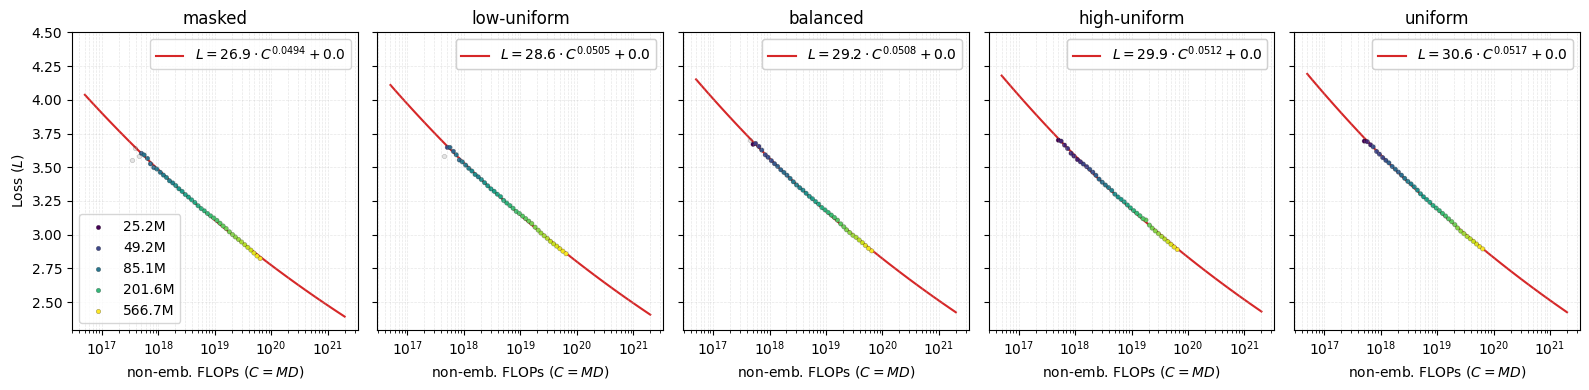

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    scaling_law = scaling_laws[hybrid_mixing_shift]["opt_loss_interpolated"]
    plot_scaling_law(ax, scaling_law)

    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

    ax.set_xlabel("non-emb. FLOPs ($C = MD$)")
    if i == 0:
        ax.set_ylabel("Loss ($L$)")
        param_handles = []
        param_labels = []
        vmin, vmax = dfi["non_emb_params"].min(), dfi["non_emb_params"].max()
        for num_flops, num_params in zip(sorted(set(M)), sorted(dfi["non_emb_params"].unique())):
            sc = ax.scatter([0], [4.4], c=np.log(num_params), vmin=np.log(vmin), vmax=np.log(vmax),
                            s=10, edgecolor=(0,0,0,0.3), linewidth=0.5)
            param_handles.append(sc)
            param_labels.append(f"{num_params/1e6:.1f}M")
        ax.legend(param_handles, param_labels, loc="lower left")

fig.tight_layout()

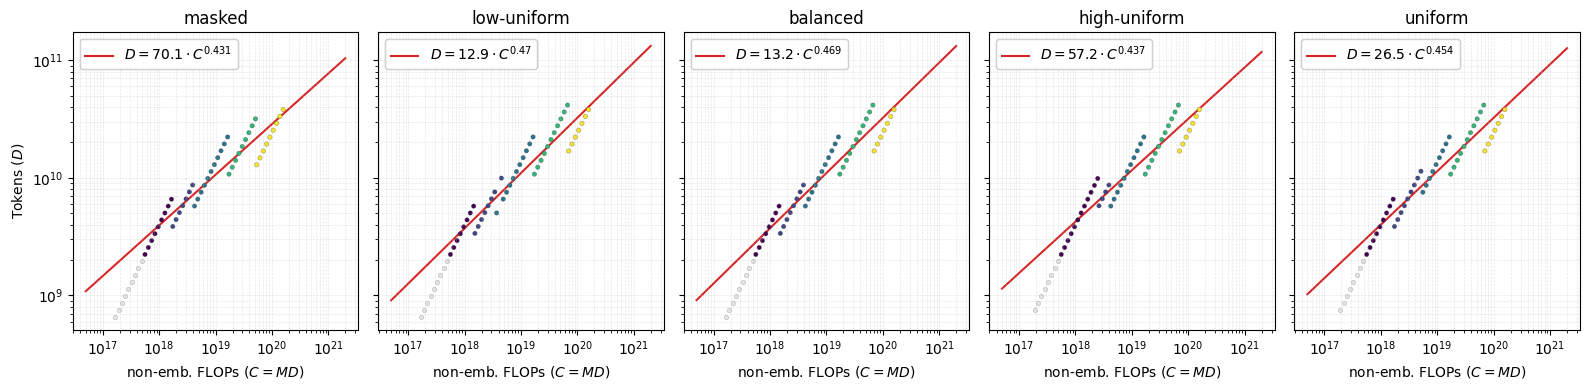

In [20]:
import scipy

fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    scaling_law = scaling_laws[hybrid_mixing_shift]["opt_data_raw"]
    plot_scaling_law(ax, scaling_law, x_symbol="C", y_symbol="D", growing=True)

    ax.set_xlabel("non-emb. FLOPs ($C = MD$)")
    if i == 0:
        ax.set_ylabel("Tokens ($D$)")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)


fig.tight_layout()

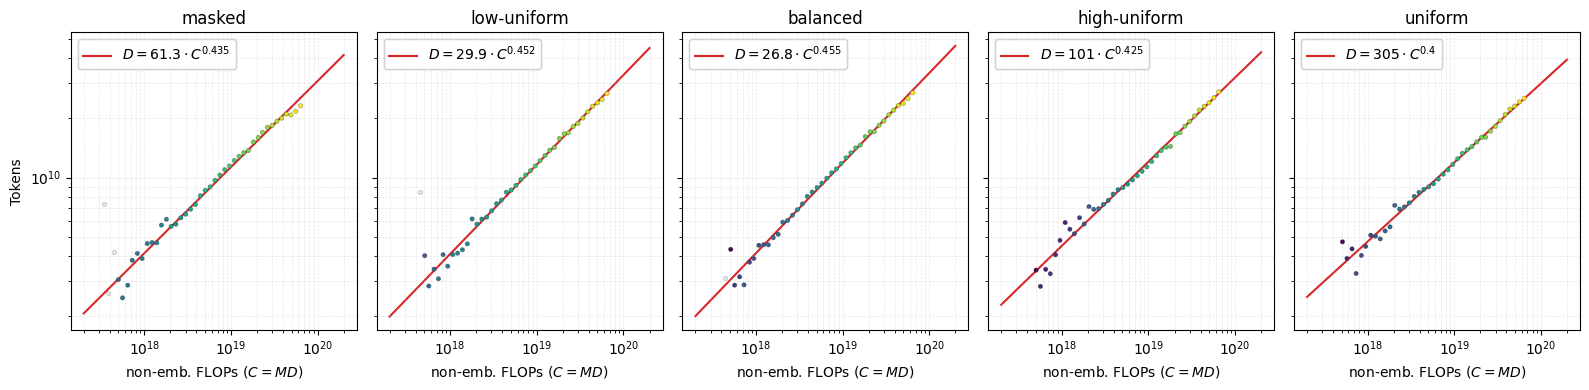

In [21]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    scaling_law = scaling_laws[hybrid_mixing_shift]["opt_data_interpolated"]
    plot_scaling_law(ax, scaling_law, x_symbol="C", y_symbol="D", min_x=2e17, max_x=2e20, growing=True)

    ax.set_xlabel("non-emb. FLOPs ($C = MD$)")
    if i == 0:
        ax.set_ylabel("Tokens")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

fig.tight_layout()

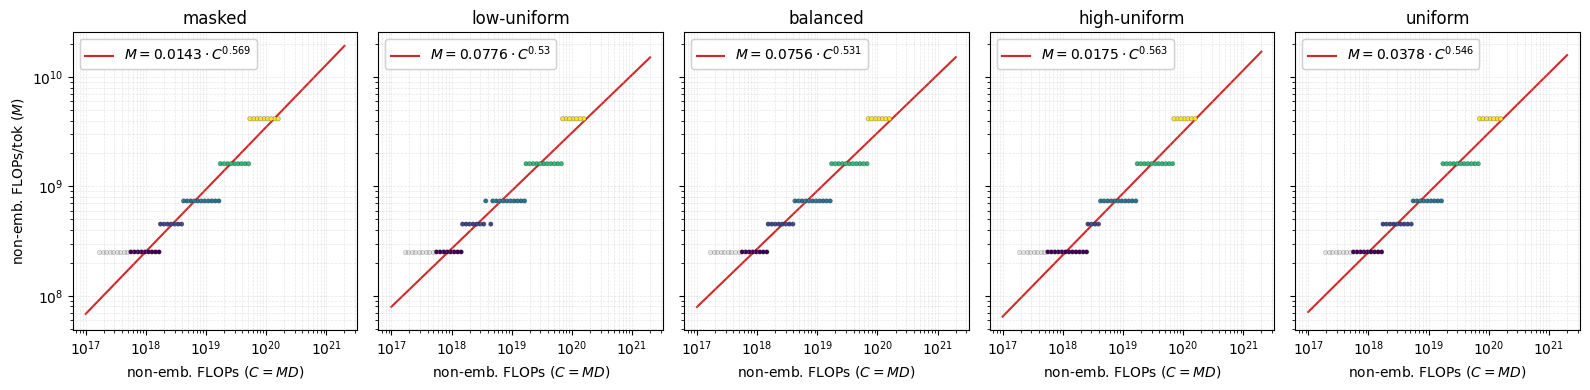

In [22]:
import scipy

fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    scaling_law = scaling_laws[hybrid_mixing_shift]["opt_flops_per_tok_raw"]
    plot_scaling_law(ax, scaling_law, x_symbol="C", y_symbol="M", growing=True, min_x=1e17, max_x=2e21)

    ax.set_xlabel("non-emb. FLOPs ($C = MD$)")
    if i == 0:
        ax.set_ylabel("non-emb. FLOPs/tok ($M$)")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)


fig.tight_layout()

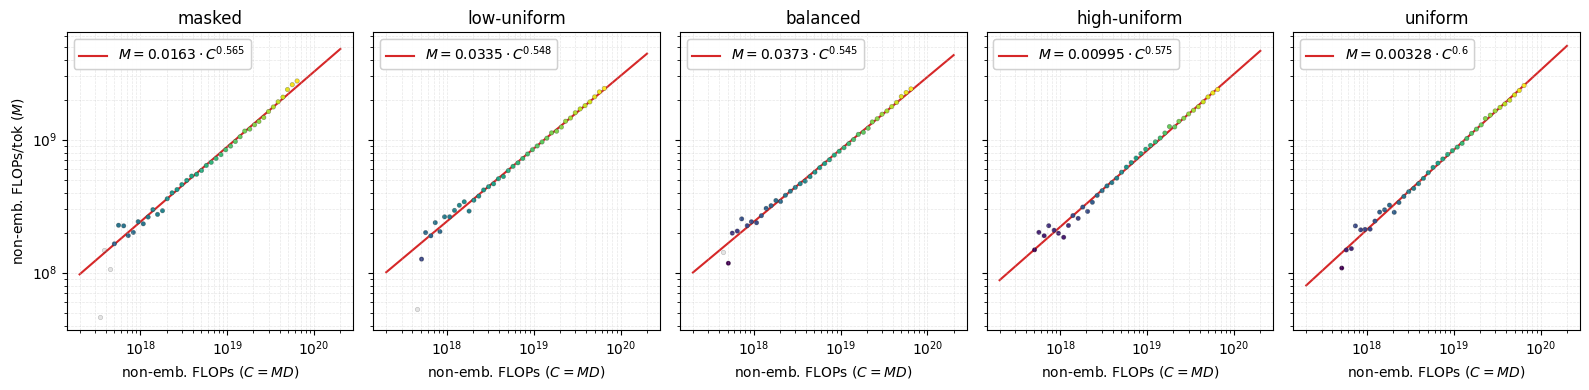

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, ((hybrid_mixing_shift,), dfi) in enumerate(df_grouped.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    scaling_law = scaling_laws[hybrid_mixing_shift]["opt_flops_per_tok_interpolated"]
    plot_scaling_law(ax, scaling_law, x_symbol="C", y_symbol="M", growing=True, min_x=2e17, max_x=2e20)

    ax.set_xlabel("non-emb. FLOPs ($C = MD$)")
    if i == 0:
        ax.set_ylabel("non-emb. FLOPs/tok ($M$)")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

fig.tight_layout()

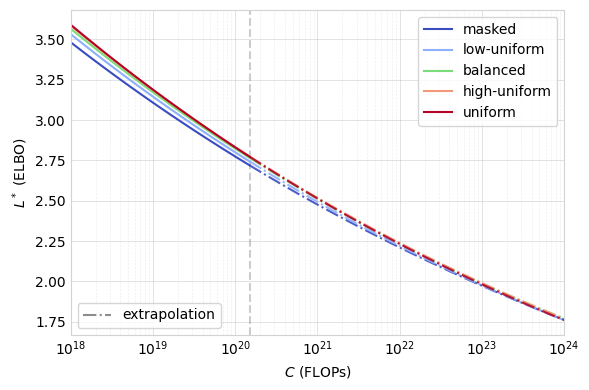

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.0))

intra_flops = np.logspace(18, np.log10(1.5e20), 50)
extra_flops = np.logspace(np.log10(1.5e20), 24, 50)
flops = np.logspace(18, 24, 100)

idx = np.argmin(np.abs(flops - 1.5e20))

ax.axvline(x=1.5e20, color="gray", linestyle="--", alpha=0.4)
ax.plot([], [], linestyle="-.", color="gray", alpha=0.9, label="extrapolation")

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = colors[hybrid_mixing_shift]
    scaling_law = scaling_law["opt_loss_interpolated"]

    a, alpha, E = scaling_law["p"]
    L_star_C_intra = scaling_law["func"](intra_flops, *scaling_law["p"])
    L_star_C_extra = scaling_law["func"](extra_flops, *scaling_law["p"])

    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(intra_flops, L_star_C_intra, linestyle="-", color=np.array(color)/255.0, label=label)
    ax.plot(extra_flops, L_star_C_extra, linestyle="-.", color=np.array(color)/255.0, alpha=0.9)


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("extrapolation") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper right")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
# ax.set_yscale("log")
# ax.legend()


# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlim(1e18, 1e24)

ax.set_xlabel("$C$ (FLOPs)")
ax.set_ylabel("$L^*$ (ELBO)")
fig.tight_layout()
fig.savefig("plots/compute_optimal_frontier.pdf", bbox_inches="tight")

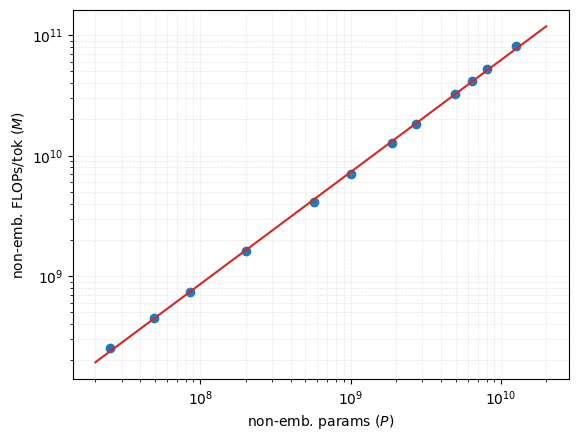

In [131]:
from notebooks.utils import params_from_config

configs = [
    (8, 8*64),
    (10, 10*64),
    (12, 12*64),
    (16, 16*64),
    (20, 12*128),
    (20, 16*128),
    (24, 20*128),
    (24, 24*128),
    (32, 32*128),
    (32, 28*128),
    (40, 32*128),
    (40, 40*128),
]
params = [params_from_config({"num_layers": l, "hidden_size": d}, include_embed_params=False) for l, d in configs]

def get_coeffs(seq_len=2048, params=params, configs=configs):
    flops_per_tok = [72 * l * d**2 + 12 * l * d * seq_len for l, d in configs]

    coeff = np.polyfit(np.log(params), np.log(flops_per_tok), 1)
    coeff_prime = np.polyfit(np.log(flops_per_tok), np.log(params), 1)
    return coeff, coeff_prime

def params_to_flops(x, seq_len=2048):
    coeff, _ = get_coeffs(seq_len=seq_len)
    return np.exp(np.polyval(coeff, np.log(x)))

def flops_to_params(x, seq_len=2048):
    _, coeff = get_coeffs(seq_len=seq_len)
    return np.exp(np.polyval(coeff, np.log(x)))

x_fit = np.logspace(np.log10(min(params))-0.1, np.log10(max(params))+0.2, 100)
y_fit = params_to_flops(x_fit)
plt.plot(x_fit, y_fit, color="C3")


plt.xlabel("non-emb. params ($P$)")
plt.ylabel("non-emb. FLOPs/tok ($M$)")
# plt.legend()

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

flops_per_tok = [72 * l * d**2 + 12 * l * d * 2048 for l, d in configs]
plt.scatter(params, flops_per_tok)
plt.xscale("log")
plt.yscale("log")

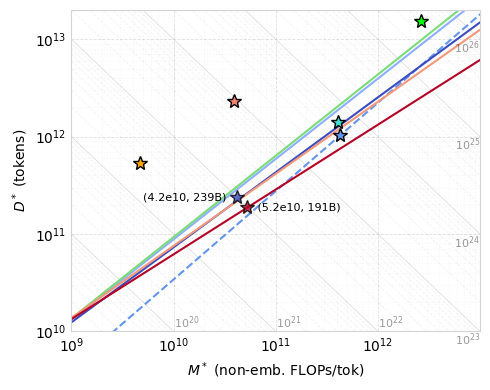

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

trained_flops = 1e22
C = np.logspace(18, 27, 100)

# MDM: P = 0.0001029 C^{0.634}
# MDM: D = 1619 C^{0.366}

M = 0.1715 * C**0.5243
D = 5.8316 * C**0.4757
ax.plot(M, D, linestyle="--", color="cornflowerblue", label="DeepSeek")

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    def get_flops_per_tok(C):
        law = scaling_law["opt_flops_per_tok_interpolated"]
        return law["func"](C, *law["p"])
    
    def get_tokens(C):
        law = scaling_law["opt_data_interpolated"]
        return law["func"](C, *law["p"])


    flops_per_tok = get_flops_per_tok(C)

    tokens = get_tokens(C)

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    label = None
    ax.plot(flops_per_tok, tokens, color=np.array(color)/255.0, label=label)

    if hybrid_mixing_shift == -1000.0:
        # M = get_flops_per_tok(trained_flops)
        # D = get_tokens(trained_flops)
        M = 4.188e10
        D = 238.8e9
        exponent = int(np.log10(np.abs(M)))
        mantissa  = M/10**exponent
        label = "Ours (masked)"
        label = None
        ax.plot([M], [D], "*", color=np.array(color)/255.0, markersize=10, markeredgecolor="black", markeredgewidth=1.0, zorder=3, label=label, alpha=0.8)
        ax.text(M, D, f"({mantissa:.1f}e{exponent}, {D/1e9:.0f}B)   ", fontsize=8, va="center", ha="right")

    
    if hybrid_mixing_shift == 1000.0:
        # M = get_flops_per_tok(trained_flops)
        # D = get_tokens(trained_flops)
        M = 5.234e10
        D = 191.04e9
        exponent = int(np.log10(np.abs(M)))
        mantissa  = M/10**exponent
        label = "Ours (uniform)"
        label = None
        ax.plot([M], [D], "*", color=np.array(color)/255.0, markersize=10, markeredgecolor="black", markeredgewidth=1.0, zorder=3, label=label, alpha=0.8)
        ax.text(M, D*0.9725, f"   ({mantissa:.1f}e{exponent}, {D/1e9:.0f}B)", fontsize=8, va="center", ha="left")

    # print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e9, 1e13*0.9999)
ax.set_ylim(1e10, 2e13)

iso_flop_values = [1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25, 1e26]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
for i, C in enumerate(iso_flop_values):
    y_line = C / x_line
    label = "ISO-FLOPs" if i == 0 else None
    label = None
    ax.plot(x_line, y_line, linestyle="-", color="black", alpha=0.13, linewidth=0.6, zorder=0, label=label)
    for i in range(2, 10):
        y_ = i * C / x_line
        ax.plot(x_line, y_, linestyle="--", color="black", alpha=0.05, linewidth=0.6, zorder=0, label=None)
    x_label = x_max
    y_label = C/x_label
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = C/y_label
        # if C == 1e21:
        #     ha = "right"
        #     x_label = x_label * 0.7
        # else:
        #     ha = "left"
        ha = "left"
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    if C > 1e19:
        ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="black", alpha=0.4)

# iso_flop_values = [5e21]
# for i, C in enumerate(iso_flop_values):
#     y_line = (C/6.0) / x_line
#     label = None
#     ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.8, linewidth=1.0, zorder=0, label=label)

#     ha = "right"
#     va = "bottom"
#     y_label = y_min
#     x_label = (C/6.0)/y_label * 0.73
#     # if not (y_min < y_label < y_max):
#     #     x_label = x_min*1.5
#     #     y_label = (C/6.0)/x_label
#     ax.text(x_label, y_label, "$5 \\times 10^{21}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.9)


# ax.plot([], [], linestyle="none", label=" ")
ax.plot([4.3e11], [1.04e12], "*", color="cornflowerblue", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="DeepSeek 67B")
ax.plot([4.02653184e11], [1.4e12], "*", color="turquoise", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Chinchilla 70B")
ax.plot([26.3818366157e11], [15.6e12], "*", color="lime", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Llama 3 405B")
ax.plot([72*32*4096**2 + 12*4096*4096], [2.3e12], "*", color="salmon", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="LLaDA 8B")
ax.plot([72*20*1792**2 + 12*2048*1792], [535e9], "*", color="orange", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Nie et al. 1.1B")


for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)


# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.4)
ax.grid(True, which="minor", linestyle=":", linewidth=0.8, alpha=0.1)

ax.set_xlabel("$M^*$ (non-emb. FLOPs/tok)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
# ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.03), frameon=False)
fig.tight_layout()
fig.savefig("plots/opt_flops_per_tok_to_tokens.pdf", bbox_inches="tight")

In [195]:
configs = [
    # (20, 20),
    # (24, 24),
    (32, 32),
    # (33, 32),
    # (34, 32),
    # (36, 32),
    (40, 32),
    # (41, 32),
    # (32, 36),
    # (34, 36),
    # (36, 36),
]

target_flops = 1e22
seq_len = 2048
micro_batch_size = 1024
step_mult = 500

def round_to_nearest_multiple(x, a=1):
    bs = int(np.round(x / a)) * a
    return max(bs, a)

def ceil_to_nearest_multiple(x, a=1):
    bs = int(np.ceil(x / a)) * a
    return max(bs, a)

B_base = 3.614098626e-3
alpha_B = 0.8179

for config in configs:
    l, h = config
    d = h * 128
    M = 72 * l * d**2 + 12 * l * d * seq_len
    D = target_flops / M
    B = B_base * (D)**alpha_B
    bs = round_to_nearest_multiple(B / seq_len, micro_batch_size)
    S = ceil_to_nearest_multiple(D / (bs * seq_len), step_mult)
    flops = S * bs * seq_len * M

    params = params_from_config({"num_layers": l, "hidden_size": d}, include_embed_params=False)
    print(f"L{l}-D{d}-H{h}: {params/1e9:.2f}B params, {M:.3e} FLOPs/tok, {D/1e9:.2f}B tokens, {B/1e6:.1f}M tok/batch, bs={bs:.0f} ({B/seq_len:.0f}), steps={S:.0f} ({D / (bs * seq_len):.0f}), flops={flops:.2e}")

L32-D4096-H32: 6.44B params, 4.188e+10 FLOPs/tok, 238.80B tokens, 7.3M tok/batch, bs=3072 (3571), steps=38000 (37956), flops=1.00e+22
L40-D4096-H32: 8.06B params, 5.234e+10 FLOPs/tok, 191.04B tokens, 6.1M tok/batch, bs=3072 (2975), steps=30500 (30365), flops=1.00e+22


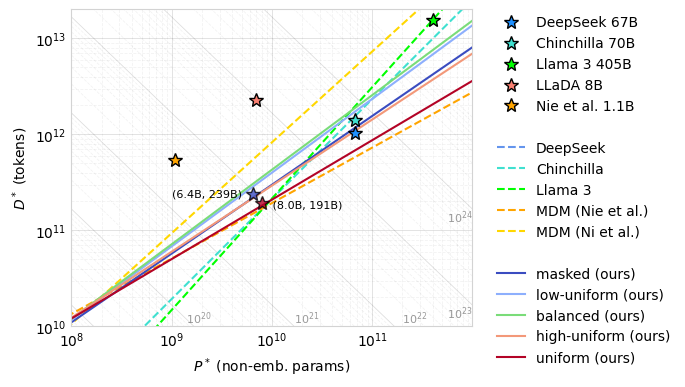

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

trained_flops = 1e22


C = np.logspace(17, 26, 100)

ax.plot([67e9], [1.04e12], "*", color="dodgerblue", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="DeepSeek 67B", zorder=3)
ax.plot([67e9], [1.4e12], "*", color="turquoise", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Chinchilla 70B", zorder=3)
ax.plot([405e9], [15.6e12], "*", color="lime", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Llama 3 405B", zorder=3)
ax.plot([6.98e9], [2.3e12], "*", color="salmon", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="LLaDA 8B", zorder=3)
ax.plot([1.082e9], [535e9], "*", color="orange", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Nie et al. 1.1B", zorder=3)
ax.plot([], [], linestyle="none", label=" ")



ax.plot([], [], linestyle="--", color="cornflowerblue", label="DeepSeek")

# M = 0.1715 * C**0.5243
# D = 5.8316 * C**0.4757
# P = flops_to_params(M, seq_len=4096)
# ax.plot(P, D, linestyle="--", color="cornflowerblue", label="DeepSeek")

P = 0.15 * C**0.49
D = 1.15 * C**0.51
ax.plot(P, D, linestyle="--", color="turquoise", label="Chinchilla")


P = 0.6 * C**0.463
D = 0.299 * C**0.537
ax.plot(P, D, linestyle="--", color="lime", label="Llama 3")

P = 0.0001029 * C**0.634
D = 1619 * C**0.366
ax.plot(P, D, linestyle="--", color="orange", label="MDM (Nie et al.)")

P = 0.0216 * C**0.514
D = 7.7 * C**0.486
ax.plot(P, D, linestyle="--", color="gold", label="MDM (Ni et al.)")

ax.plot([], [], linestyle="none", label=" ")




for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    def get_params(flops):
        law = scaling_law["opt_flops_per_tok_interpolated"]
        flops_per_tok = law["func"](flops, *law["p"])
        return flops_to_params(flops_per_tok, seq_len=2048)
    
    def get_data(flops):
        law = scaling_law["opt_data_interpolated"]
        return law["func"](flops, *law["p"])

    color = colors[hybrid_mixing_shift]


    # law = scaling_law["opt_flops_per_tok_interpolated"]
    # flops_per_tok = law["func"](C, *law["p"])
    # params = flops_to_params(flops_per_tok)
    params = get_params(C)

    # law = scaling_law["opt_data_interpolated"]
    # tokens = law["func"](C, *law["p"])
    tokens = get_data(C)

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift) + " (ours)"
    # label = None
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)

    if hybrid_mixing_shift == -1000.0:
        # P = get_params(trained_flops)
        # D = get_data(trained_flops)
        P = 6.44e9
        D = 238.8e9
        label = "Ours (masked)"
        label = None
        ax.plot([P], [D], "*", color=np.array(color)/255.0, markersize=10, markeredgecolor="black", markeredgewidth=1.0, zorder=3, label=label, alpha=0.8)
        ax.text(P, D, f"({P/1e9:.1f}B, {D/1e9:.0f}B)   ", fontsize=8, va="center", ha="right")

    
    if hybrid_mixing_shift == 1000.0:
        # P = get_params(trained_flops)
        # D = get_data(trained_flops)
        P = 8.04e9
        D = 191.04e9
        label = "Ours (uniform)"
        label = None
        ax.plot([P], [D], "*", color=np.array(color)/255.0, markersize=10, markeredgecolor="black", markeredgewidth=1.0, zorder=3, label=label, alpha=0.8)
        ax.text(P, D*0.9725, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="center", ha="left")

    # print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e12*0.9999)
ax.set_ylim(1e10, 2e13)


iso_flop_values = [1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
# M = params_to_flops(x_line)
# M_max = params_to_flops(x_max)
M = 6 * x_line
M_max = 6 * x_max
for i, C in enumerate(iso_flop_values):
    y_line = C / M
    label = "ISO-FLOPs" if i == 0 else None
    label = None
    ax.plot(x_line, y_line, linestyle="-", color="black", alpha=0.13, linewidth=0.6, zorder=0, label=label)
    for i in range(2, 10):
        y_ = i * C / M
        ax.plot(x_line, y_, linestyle="--", color="black", alpha=0.05, linewidth=0.6, zorder=0, label=None)
    x_label = x_max
    y_label = C/M_max
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = flops_to_params(C/y_label)
        # if C == 1e21:
        #     ha = "right"
        #     x_label = x_label * 0.7
        # else:
        #     ha = "left"
        ha = "left"
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    if C > 1e19:
        ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="black", alpha=0.4)

for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)


# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

ax.grid(True, which="major", linestyle="-", color="black", linewidth=0.6, alpha=0.13)
ax.grid(True, which="minor", linestyle="--", color="black", linewidth=0.6, alpha=0.05)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend(loc="upper left", bbox_to_anchor=(1.03, 1.02), frameon=False)
fig.tight_layout()
fig.savefig("plots/opt_params_to_tokens.pdf", bbox_inches="tight")

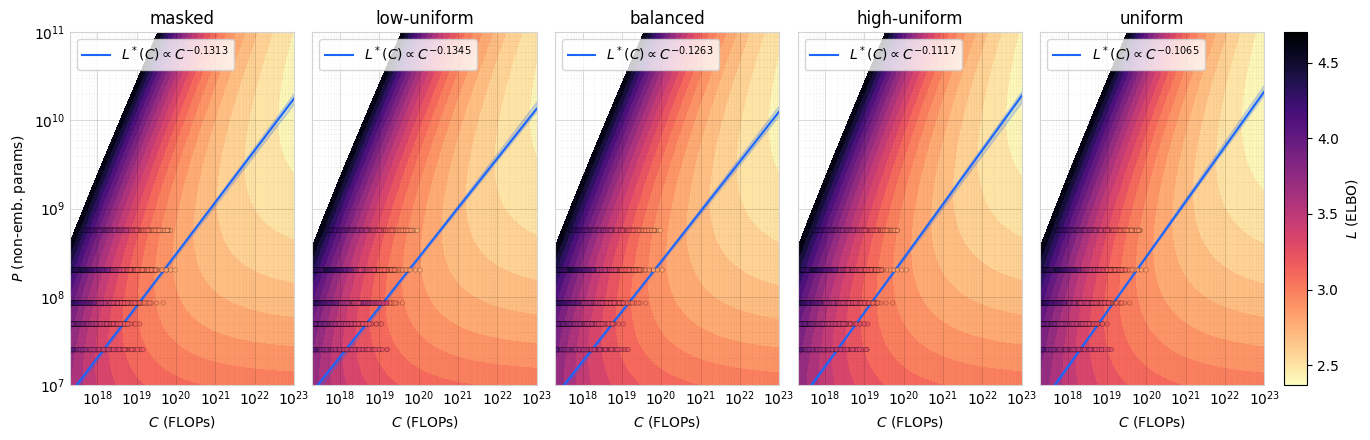

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(13, 4.5), sharex=True, sharey="row")

vmin, vmax = 2.37, 4.7
cmap = "magma_r"
norm = plt.Normalize(vmin=vmin, vmax=vmax)

flops = np.logspace(17, 23, 100)
params = np.logspace(7, 11, 100)
X, Y = np.meshgrid(flops, params)
tokens = X / (6 * Y)



def eval_bootstrap_params(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    # L_star_P = E + a*(alpha + beta)/beta * params[None,:]**(-alpha)
    p_opt = ((alpha*a)/(beta*b))**(1/(alpha+beta)) * (flops/6)**(beta/(alpha+beta))
    lower = np.percentile(p_opt, percentile_alpha, axis=0)
    upper = np.percentile(p_opt, 100 - percentile_alpha, axis=0)
    return lower, upper




for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    ax = axs[i]
    a, alpha, b, beta, E = scaling_law["p"]
    loss = E + a * Y**-alpha + b * tokens**-beta

    levels = np.logspace(np.log10(vmin), np.log10(vmax), 20)
    # levels = np.concatenate([np.array([0.0]), levels])
    ax.contourf(X, Y, loss, levels=levels, cmap=cmap, norm=norm)

    p_opt = ((alpha*a)/(beta*b))**(1/(alpha+beta)) * (flops/6)**(beta/(alpha+beta))
    expo = beta/(alpha+beta)
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    color = (0.1, 0.4, 1.0)
    ax.plot(flops, p_opt, linestyle="-", color=color, label="$L^*(C) \\propto C^{{{:.4g}}}$".format(C_star_alpha))


    lower, upper = eval_bootstrap_params(scaling_law["p_bootstrap"].T, flops)
    ax.fill_between(flops, lower, upper, alpha=0.2, color=color)

    dfi = df_.filter(pl.col("hybrid_mixing_shift") == hybrid_mixing_shift)
    ps, ts, ls = dfi["non_emb_params"], dfi["tokens"], dfi["target_loss"]
    ax.scatter(6*ps*ts, ps, c=ls, cmap=cmap, norm=norm, edgecolor=(0,0,0,0.3), linewidth=0.5, s=10, zorder=2)
    
    # ax.plot([], [], "-", color=(0.0, 0.0, 0.0, 0.3), label=f"")

    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_title(get_noise_label(hybrid_mixing_shift))
    ax.set_ylim(1e7, 1e11)
    ax.set_xlim(2e17, 1e23)
    if i == 0: ax.set_ylabel("$P$ (non-emb. params)")
    ax.set_xlabel("$C$ (FLOPs)")
    ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.2, color="black")
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.05, color="black")


    ax.legend(loc="upper left")


for ax in axs.flatten():
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')
    ax.tick_params(which="both", length=0, width=0)

fig.tight_layout(w_pad=0.2)

box = axs[-1].get_position()
cax_w, pad = 0.018, 0.015
cax = fig.add_axes([box.x0 + box.width + pad, box.y0, cax_w, box.height])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
fig.colorbar(sm, cax=cax, label="$L$ (ELBO)")
cax.yaxis.set_ticks_position('right'); cax.yaxis.set_label_position('right')

fig.savefig("plots/params_vs_flops.pdf", bbox_inches="tight")


masked: $L^*(C) = 10^{2.347} \cdot C^{-0.1313} + 2.153$
low-uniform: $L^*(C) = 10^{2.41} \cdot C^{-0.1345} + 2.178$
balanced: $L^*(C) = 10^{2.297} \cdot C^{-0.1263} + 2.122$
high-uniform: $L^*(C) = 10^{2.084} \cdot C^{-0.1117} + 2.013$
uniform: $L^*(C) = 10^{2.018} \cdot C^{-0.1065} + 1.940$


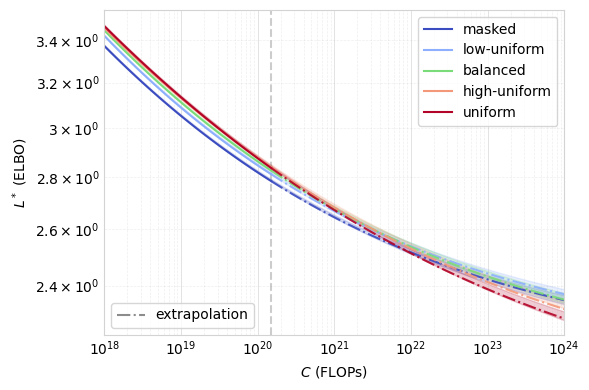

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.0))

intra_flops = np.logspace(18, np.log10(1.5e20), 50)
extra_flops = np.logspace(np.log10(1.5e20), 24, 50)
flops = np.logspace(18, 24, 100)

idx = np.argmin(np.abs(flops - 1.5e20))

ax.axvline(x=1.5e20, color="gray", linestyle="--", alpha=0.4)
ax.plot([], [], linestyle="-.", color="gray", alpha=0.9, label="extrapolation")

def eval_bootstrap_flops(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    L_star_C = E + C_star_a * (flops[None,:]/6)**C_star_alpha
    lower = np.percentile(L_star_C, percentile_alpha, axis=0)
    upper = np.percentile(L_star_C, 100 - percentile_alpha, axis=0)
    return lower, upper

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    lower_intra, upper_intra = eval_bootstrap_flops(scaling_law["p_bootstrap"].T, intra_flops)
    L_star_C_intra = E + C_star_a * (intra_flops/6)**C_star_alpha
    lower_extra, upper_extra = eval_bootstrap_flops(scaling_law["p_bootstrap"].T, extra_flops)
    L_star_C_extra = E + C_star_a * (extra_flops/6)**C_star_alpha


    # if hybrid_mixing_shift == -1000.0:
    #     C = 5e21
    #     L = E + C_star_a * (C/6)**C_star_alpha
    #     ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
    #     ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
    #     ax.text(1e18, L, f" {L:.3f}", fontsize=8, va="bottom", ha="left", color=np.array(color)/255.0, alpha=0.8)

    
    # if hybrid_mixing_shift == 1000.0:
    #     C = 5e21
    #     L = E + C_star_a * (C/6)**C_star_alpha
    #     ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
    #     ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
    #     ax.text(1e18, L*0.996, f" {L:.3f}", fontsize=8, va="top", ha="left", color=np.array(color)/255.0, alpha=0.8)

    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(intra_flops, L_star_C_intra, linestyle="-", color=np.array(color)/255.0, label=label)
    ax.fill_between(intra_flops, lower_intra, upper_intra, alpha=0.2, color=np.array(color)/255.0)
    ax.plot(extra_flops, L_star_C_extra, linestyle="-.", color=np.array(color)/255.0, alpha=0.9)
    ax.fill_between(extra_flops, lower_extra, upper_extra, alpha=0.2, color=np.array(color)/255.0)

    print(get_noise_label(hybrid_mixing_shift) + ": $L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E))


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("extrapolation") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper right")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.legend()


# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)



for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlim(1e18, 1e24)

ax.set_xlabel("$C$ (FLOPs)")
ax.set_ylabel("$L^*$ (ELBO)")
fig.tight_layout()
fig.savefig("plots/compute_optimal_frontier.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.588}, D^* \propto C^{0.412}
low-uniform: P^* \propto C^{0.563}, D^* \propto C^{0.437}
balanced: P^* \propto C^{0.567}, D^* \propto C^{0.433}
high-uniform: P^* \propto C^{0.614}, D^* \propto C^{0.386}
uniform: P^* \propto C^{0.625}, D^* \propto C^{0.375}


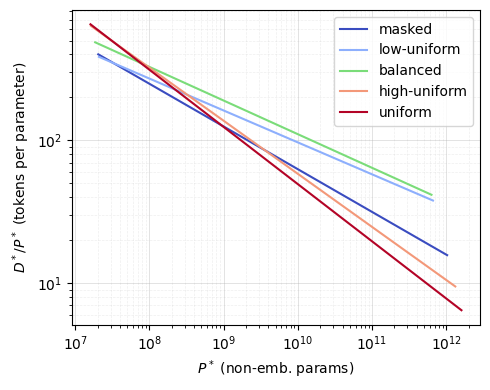

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

def bootstrap_flops_on_params(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    params = P_star_a * (flops[None,:]/6)**P_star_alpha
    tokens = D_star_a * (flops[None,:]/6)**D_star_alpha

    # # bin and hist
    # params = params.ravel()
    # tokens = tokens.ravel()
    # n_bins = 100
    # bins = np.logspace(8, 11, n_bins + 1)
    #
    # # Assign bins (idx in [0, n_bins-1]); drop out-of-range and non-finite
    # idx = np.digitize(params, bins) - 1
    # valid = (idx >= 0) & (idx < n_bins) & np.isfinite(params) & np.isfinite(tokens)
    # x, y, idx = params[valid], tokens[valid], idx[valid]
    #
    # # Prepare outputs
    # counts = np.bincount(idx, minlength=n_bins)
    # q = np.array([percentile_alpha, 100 - percentile_alpha])
    # out = np.full((n_bins, q.size), np.nan)
    #
    # # Compute percentiles per bin
    # for i in range(n_bins):
    #     if counts[i] < 1:
    #         continue
    #     yi = y[idx == i]
    #     if yi.size == 0:
    #         continue
    #     else:
    #         out[i] = np.percentile(yi, q)
    #
    # # Bin centers (geometric is handy for log-scaled x)
    # bin_center = np.sqrt(bins[:-1] * bins[1:])
    #
    # return bin_center, out[:,0], out[:,1]

    med_p = np.percentile(params, 50.0, axis=0)
    lo_d, hi_d = np.percentile(tokens, [percentile_alpha, 100.0 - percentile_alpha], axis=0)
    return med_p, lo_d, hi_d



for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(params, tokens/params, color=np.array(color)/255.0, label=label)

    # do the bootstrop
    # med_p, lo_d, hi_d = bootstrap_flops_on_params(scaling_law["p_bootstrap"].T, flops)
    # ax.fill_between(med_p, lo_d, hi_d, alpha=0.25, color=np.array(color)/255.0)

    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")



ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(1e8, 1e11)
# ax.set_ylim(3e10, 2e13)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*/P^*$ (tokens per parameter)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend()
fig.tight_layout()
#fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.588}, D^* \propto C^{0.412}
low-uniform: P^* \propto C^{0.563}, D^* \propto C^{0.437}
balanced: P^* \propto C^{0.564}, D^* \propto C^{0.436}
high-uniform: P^* \propto C^{0.614}, D^* \propto C^{0.386}
uniform: P^* \propto C^{0.625}, D^* \propto C^{0.375}


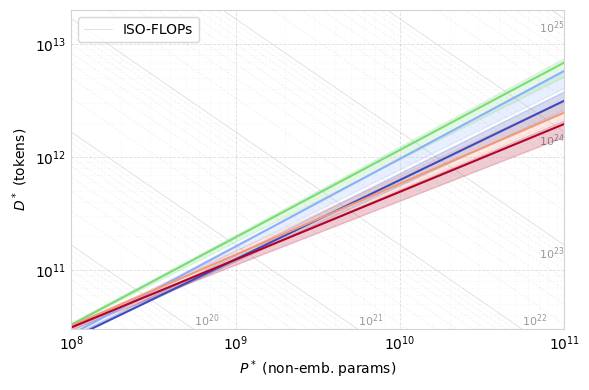

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

trained_flops = 5e21


def bootstrap_flops_on_params(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    params = P_star_a * (flops[None,:]/6)**P_star_alpha
    tokens = D_star_a * (flops[None,:]/6)**D_star_alpha

    # # bin and hist
    # params = params.ravel()
    # tokens = tokens.ravel()
    # n_bins = 100
    # bins = np.logspace(8, 11, n_bins + 1)
    #
    # # Assign bins (idx in [0, n_bins-1]); drop out-of-range and non-finite
    # idx = np.digitize(params, bins) - 1
    # valid = (idx >= 0) & (idx < n_bins) & np.isfinite(params) & np.isfinite(tokens)
    # x, y, idx = params[valid], tokens[valid], idx[valid]
    #
    # # Prepare outputs
    # counts = np.bincount(idx, minlength=n_bins)
    # q = np.array([percentile_alpha, 100 - percentile_alpha])
    # out = np.full((n_bins, q.size), np.nan)
    #
    # # Compute percentiles per bin
    # for i in range(n_bins):
    #     if counts[i] < 1:
    #         continue
    #     yi = y[idx == i]
    #     if yi.size == 0:
    #         continue
    #     else:
    #         out[i] = np.percentile(yi, q)
    #
    # # Bin centers (geometric is handy for log-scaled x)
    # bin_center = np.sqrt(bins[:-1] * bins[1:])
    #
    # return bin_center, out[:,0], out[:,1]

    med_p = np.percentile(params, 50.0, axis=0)
    lo_d, hi_d = np.percentile(tokens, [percentile_alpha, 100.0 - percentile_alpha], axis=0)
    return med_p, lo_d, hi_d

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]


    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    label = None
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)

    # do the bootstrop
    med_p, lo_d, hi_d = bootstrap_flops_on_params(scaling_law["p_bootstrap"].T, flops)
    ax.fill_between(med_p, lo_d, hi_d, alpha=0.2, color=np.array(color)/255.0)
    
    # if hybrid_mixing_shift == -1000.0:
    #     P = P_star_a * (trained_flops/6)**P_star_alpha
    #     D = D_star_a * (trained_flops/6)**D_star_alpha
    #     ax.plot([P], [D], "o", color=np.array(color)/255.0)
    #     ax.text(P, D, f"  ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")

    
    # if hybrid_mixing_shift == 1000.0:
    #     P = P_star_a * (trained_flops/6)**P_star_alpha
    #     D = D_star_a * (trained_flops/6)**D_star_alpha
    #     ax.plot([P], [D], "o", color=np.array(color)/255.0)
    #     ax.text(P, D, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")

    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e11)
ax.set_ylim(3e10, 2e13)

iso_flop_values = [1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
for i, C in enumerate(iso_flop_values):
    y_line = (C/6.0) / x_line
    label = "ISO-FLOPs" if i == 0 else None
    ax.plot(x_line, y_line, linestyle="-", color="black", alpha=0.13, linewidth=0.6, zorder=0, label=label)
    for i in range(2, 10):
        y_ = i * (C/6.0) / x_line
        ax.plot(x_line, y_, linestyle="--", color="black", alpha=0.05, linewidth=0.6, zorder=0, label=None)
    x_label = x_max
    y_label = (C/6.0)/x_label
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = (C/6.0)/y_label
        # if C == 1e21:
        #     ha = "right"
        #     x_label = x_label * 0.7
        # else:
        #     ha = "left"
        ha = "left"
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    if C > 1e19:
        ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="black", alpha=0.4)

# iso_flop_values = [5e21]
# for i, C in enumerate(iso_flop_values):
#     y_line = (C/6.0) / x_line
#     label = None
#     ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.8, linewidth=1.0, zorder=0, label=label)

#     ha = "right"
#     va = "bottom"
#     y_label = y_min
#     x_label = (C/6.0)/y_label * 0.73
#     # if not (y_min < y_label < y_max):
#     #     x_label = x_min*1.5
#     #     y_label = (C/6.0)/x_label
#     ax.text(x_label, y_label, "$5 \\times 10^{21}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.9)


for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)


# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.4)
ax.grid(True, which="minor", linestyle=":", linewidth=0.8, alpha=0.1)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")